In [1]:
# Imports 
import cv2
import re
import pytesseract
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from os.path import exists
from typing import Callable

### Util Functions

In [2]:
def plot(
    imgs, n_rows: int, n_cols: int, axis=True
) -> None:
    """
    Plot a list of images using MatPlotLib.

    Parameters
    ----------
    imgs: images to be plotted
    n_rows: number of rows in the grid
    n_cols: number of columns in the grid
    axis: should the axis be shown in the subplots
    """
    actual_n_rows = len(imgs) // n_cols
    n_cols_last_row = len(imgs) - (actual_n_rows - 1) * n_cols

    for i in range(1, actual_n_rows + 1):
        for j in range(1, n_cols_last_row + 1):
            img = imgs[(index := (i - 1) * n_cols + j) - 1]
            plt.subplot(int(f"{n_rows}{n_cols}{index}"))
            plt.axis("on" if axis else "off")
            plt.title(img["title"])
            plt.imshow(img["image"], cmap=img["cmap"] if "cmap" in img else "gray")

    plt.show()

In [3]:
def clean(img: NDArray) -> NDArray:
    """
    Apply a cleaning (image procesing) pipeline to an image. The pipeline's core
    consists in morphological dilation and image subtraction.

    Parameters
    ----------
    img: the image to be processed

    Returns
    -------
    The processed image
    """
    # remove text using dilatation and median blur - this
    # leaves only the background (including noise and shadows)
    dilated_img = cv2.dilate(img, np.ones((7, 7)))
    background_img = cv2.medianBlur(dilated_img, 21)

    # subtract the background + noise + shadow from
    # the original image - this leaves only the text
    foreground_img = 255 - cv2.absdiff(img, background_img)

    # normalize the image
    normalized_img = foreground_img
    cv2.normalize(
        normalized_img,
        normalized_img,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
    )

    # truncate image and normalize again
    _, truncated_img = cv2.threshold(normalized_img, 230, 0, cv2.THRESH_TRUNC)
    cv2.normalize(
        truncated_img,
        truncated_img,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
    )

    return truncated_img

In [4]:
def parse_float(number: str) -> float:
    """Parse a comma-separated decimal number to a float rounded to 2 decimal places."""
    return round(float(number.replace(",", ".")), 2)

In [5]:
def get_n_leading_zeros(length: int) -> int:
    """
    Calculate the necessary number of leading zeros to consistently enumerate all elements in a list of given length.

    Parameters
    ----------
    length: how many elements there are in the list to be enumerated

    Returns
    -------
    Number of leading zeros necessary.
    """
    return len(str(length))

In [6]:
def image_exists(filepath: str) -> bool:
    """Check if a filepath refers to a PNG or JPG file that exists."""
    return (filepath.endswith(".png") or filepath.endswith(".jpg")) and exists(filepath)

In [7]:
def prompt(
    text: str,
    validate,
    err: str = "Invalid input, try again.",
) -> str:
    """
    Prompt user for input and only return when the input is valid.

    Parameters
    ----------
    text: input prompt.
    validate?: validator for the input - if none is provided, all input is considered valid.
               It should receive a string to validate as parameter and return a bool.
    err error message in case validation fails. Defaults to: "Invalid input, try again."

    Returns
    -------
    The user's validated input.
    """
    if not text.endswith("\n"):
        text += " "
    r = input(text)
    if validate:
        is_valid = validate(r)
        while not is_valid:
            r = input(f"\n{err} {text}")
            is_valid = validate(r)
    return r

### Define the class Product

texto explicativo da classe

In [8]:
class Product:
    """Represent a grocery product."""

    __name: str
    """The product's name."""
    __quantity: float
    """The quantity that was bought (can be in units, kilograms, etc)."""
    __measurement_unity: str
    """The measurement unit used in `__quantity`: units, kilograms, etc."""
    __unit_price: float
    """The price of one unit/kilogram/etc of this product."""
    __price: float
    """The total value spent on purchasing this product."""
    __pricing_inconsistent: bool
    """
    If the total price read from the raw text is too different from the on
    calculated through the quantity and unit price.
    """

    def __init__(self, raw: str):
        # use regex to extract relevant info
        matches: list[tuple[str, ...]] = re.findall(
            r"^\S*\s*[a-z\s]*(.+?)\s*(\d*,?\d*(UN|KG))\s*x\s*(\d*,?\d*)\(?[\d,]*\)?.+?(\d*,?\d*)$",
            self.__substitute_common_mistakes(raw.strip()),
        )

        if not matches:
            raise RuntimeError("Product data couldn't be parsed.")

        name, quantity, unity, unit_price, price = matches[0]

        # format and save data
        try:
            self.__name = name.title()
            self.__quantity = parse_float(quantity.replace(unity, ""))
            self.__measurement_unity = unity.lower()
            self.__unit_price = parse_float(unit_price)
            calculated_price = round(self.__unit_price * self.__quantity, 2)
            self.__price = parse_float(price) if price else calculated_price
            self.__pricing_inconsistent = abs(calculated_price - self.__price) > 1
        except Exception:
            raise RuntimeError("Product data couldn't be parsed.")

    def __str__(self) -> str:
        representation = [
            f"Product name: {self.get_name()}\n",
            f"Quantity bought: {self.get_quantity()}",
            " (maybe)\n" if self.__pricing_inconsistent else "\n",
            f"Price per {self.__measurement_unity}.: R${self.get_unit_price()}",
            " (maybe)\n" if self.__pricing_inconsistent else "\n",
            f"Total price: R${self.get_price()}",
            " (maybe)" if self.__pricing_inconsistent else "",
        ]
        return "".join(representation)

    def get_quantity(self) -> str:
        return f"{self.__quantity} {self.__measurement_unity}."

    def get_name(self) -> str:
        return self.__name

    def get_unit_price(self) -> float:
        return self.__unit_price

    def get_price(self) -> float:
        return self.__price

    def get_price_inconsistency(self) -> bool:
        return self.__pricing_inconsistent

    def __substitute_common_mistakes(self, raw: str) -> str:
        """Correct common OCR mistakes from when parsing a grocery product from a receipt photo."""
        return (
            raw.replace("\n", " ")
            .replace("]", "I")
            .replace("[", "L")
            .replace("k9", "kg")
            .replace("JUN", "1UN")
            .replace("TUN", "1UN")
            .replace("IUN", "1UN")
            .replace("LUN", "1UN")
            .replace(" UN", " 1UN")
            .replace("lUN", "1UN")
        )

### Define the class Receipt

texto explicativo da classe

In [9]:
class Receipt:
    """Represent a grocery receipt."""

    __products: list[Product] = []
    """All grocery products in a receipt."""
    __value: float
    """The receipt's total value/price."""
    __pricing_inconsistent: bool
    """
    If the total price read from the raw text is too different from the on
    calculated through the sum of all products.
    """

    def __init__(self, raw: str):
        items_indexes = re.findall(r"^\d+\s+", raw, re.IGNORECASE + re.MULTILINE)
        price_regex = r"^Total\s*R\$\s*(\d{1,},\d{2}).*$"
        price_line = re.search(price_regex, raw, re.IGNORECASE + re.MULTILINE)

        # search for the total price line in the raw text
        if price_line:
            price_line_start, _ = price_line.span()
            price = re.findall(price_regex, raw, re.IGNORECASE + re.MULTILINE)[0]
            products_raw = raw[:price_line_start]
        else:
            price = None
            products_raw = raw

        # split products raw text into a list
        split_pivot = "||<<>>####+####<<>>||"
        for i in items_indexes:
            products_raw = products_raw.replace(i, split_pivot)
        products_raw_arr = products_raw.split(split_pivot)[1:]

        # parse products and save the successful ones
        for p_raw in products_raw_arr:
            try:
                product = Product(p_raw)
            except RuntimeError:
                pass
            else:
                self.__products.append(product)

        if not self.__products:
            raise RuntimeError("The receipt's products' data could not be parsed")

        # save the total price
        try:
            sum_products = sum([p.get_price() for p in self.__products])
            inconsistent = not price and any(
                [p.get_price_inconsistency() for p in self.__products]
            )
            self.__value = parse_float(price) if price else round(sum_products, 2)
            self.__pricing_inconsistent = (
                inconsistent or abs(sum_products - self.__value) > 3
            )
        except Exception:
            raise RuntimeError("The receipt's products' data could not be parsed")

    def __str__(self):
        n_leading_zeros = get_n_leading_zeros(len(self.__products))
        string = "\n\n".join(
            [
                f"Product #{str(i + 1).zfill(n_leading_zeros)}\n{p}"
                for i, p in enumerate(self.__products)
            ]
        )
        string += f"\n\nTOTAL RECEIPT VALUE: R${self.get_value()}"
        string += " (maybe)" if self.__pricing_inconsistent else ""
        return string

    def get_products(self):
        return self.__products

    def get_value(self):
        return self.__value

### Main Program 

daqui para baixo é a função contida em main.py a função principal

#### Read original image path

Change the number from img00.jpg to choose other image

In [10]:
image_filepath = "./receipts/cropped/img00.jpg"

 #### Load image

In [11]:
original_img: NDArray = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE) # Load image in grayscale mode

#### Print original image

Representation of original image

In [12]:
 original_img

array([[191, 193, 194, ..., 183, 182, 183],
       [192, 192, 192, ..., 183, 183, 182],
       [194, 192, 191, ..., 184, 184, 184],
       ...,
       [125, 120, 116, ..., 187, 187, 187],
       [125, 121, 118, ..., 186, 187, 187],
       [127, 124, 122, ..., 187, 187, 187]], dtype=uint8)

Taking the original images' shape. N is the number of rows and M is the number of colunes.

In [13]:
N,M = np.shape(original_img)
print(N,M)

1525 1645


Plot the original image (in gray scale).
This is how the image looks when loaded.

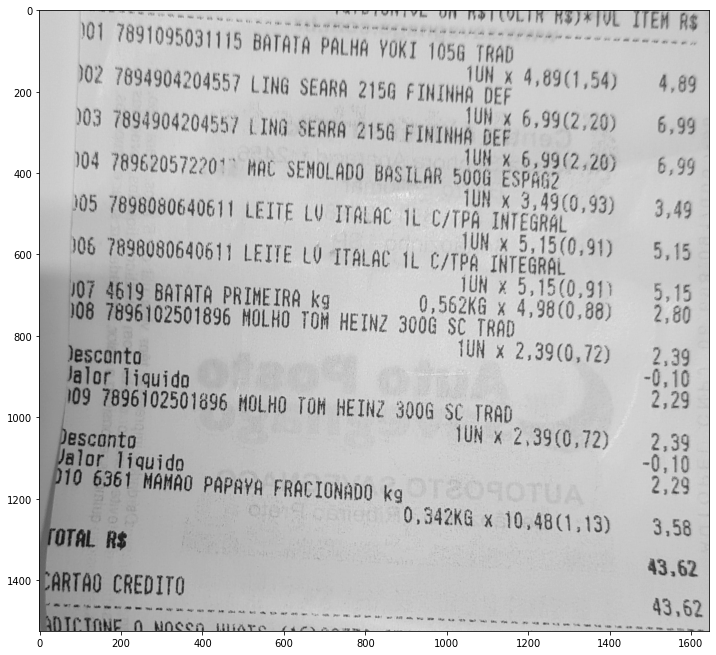

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(original_img, cmap = "gray")

#### Image Process

##### 1. Performing a image thresholding using the otsu binarization method.

In [15]:
# apply otsu binarization to the pre-processed image
otsu_img: NDArray
_, otsu_img = cv2.threshold(
    clean(original_img),
    0,
    255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)

Numerical representation of image after applying the otsu method.

In [16]:
otsu_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Plot the image

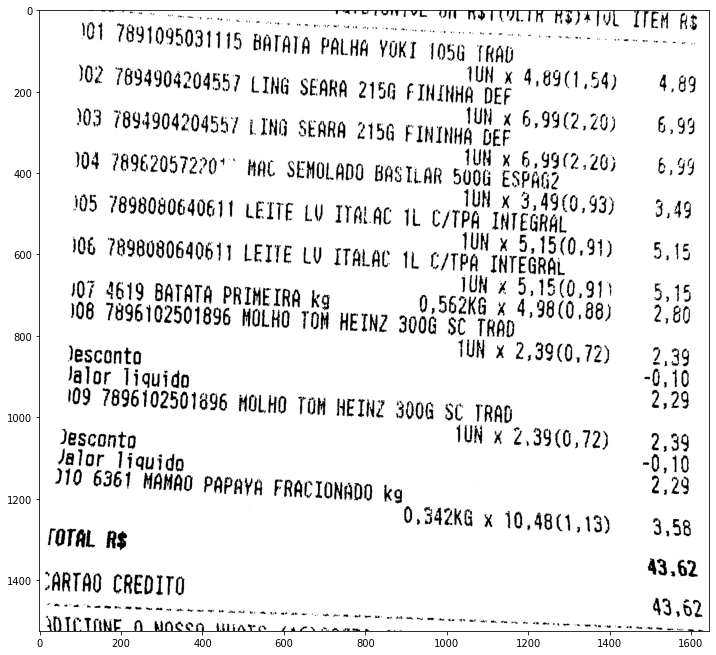

In [17]:
plt.figure(figsize=(12,12))
plt.imshow(otsu_img, cmap = "gray")

##### 2. Apply opening to the image

In [18]:
# apply morphological opening in order to close gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
morph_img = cv2.morphologyEx(otsu_img, cv2.MORPH_OPEN, kernel)

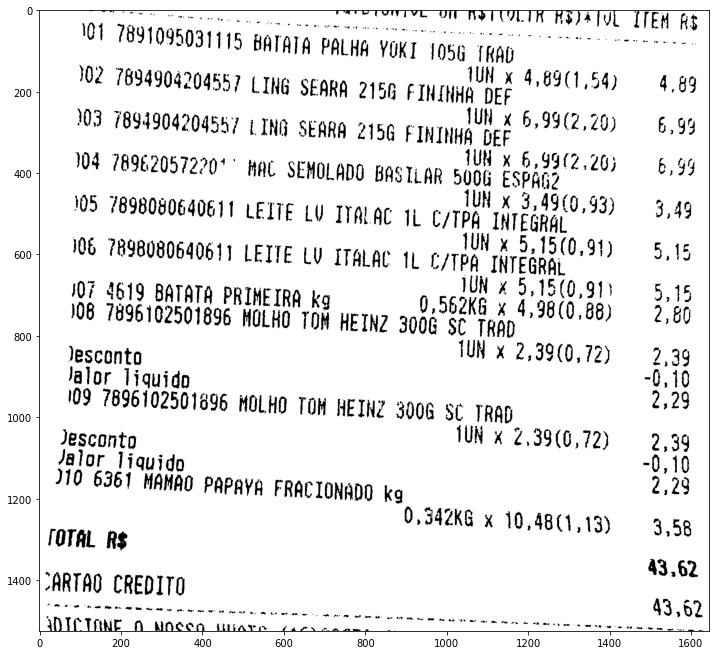

In [19]:
plt.figure(figsize=(12,12))
plt.imshow(morph_img, cmap = "gray")

The output image of opening process is not clear in the visualization of this image. To see the difference between the image pre-opening and pos-opening lets show the comparison using cropped segments of each image (otsu_img and morph_img).

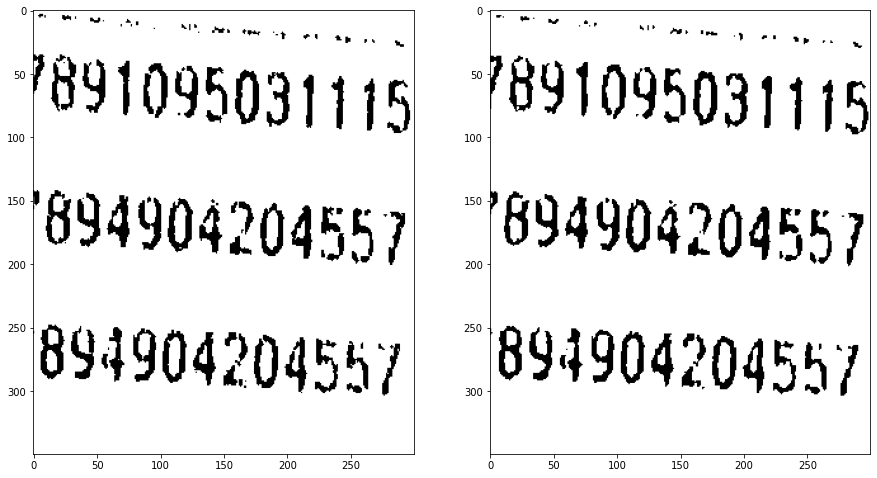

In [20]:
cropped_otsu = otsu_img[0:350,200:500]
cropped_morph = morph_img[0:350,200:500]
plt.figure(figsize=(15,15))
plt.subplot(121); plt.imshow(cropped_otsu, cmap = "gray")
plt.subplot(122); plt.imshow(cropped_morph, cmap = "gray")

##### 3. Optical Character Recognition

###### 3.1 About the training

As mentioned in the report, [Tesstrain](https://github.com/tesseract-ocr/tesstrain) was used for create a trained model for tesseract. The model created from ours training data is in file [grocery.traineddata](./ocr-training/grocery.traineddata). To run the project is necessary copy this file, together with [Portuguese trained modelo](https://github.com/tesseract-ocr/tessdata_best/blob/main/por.traineddata) and [English trained modelo](https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata), to the folder *tessdata* in your machine.

Using the Tesseract(which is a optical caractere recognition) with Python, all text in the image was converted to a string.

In [21]:
# apply OCR
text: str = pytesseract.image_to_string(
    morph_img, lang="por+grocery+eng", config="--oem 1 --psm 1"
)

Seeing the content of text variable

In [22]:
print(type(text))
print(text)

<class 'str'>
e t1T1VL ET VOA 17 SI TEN ‘AS

101 7891095031115 BATATA PALHA YOKI 1056 | tha
x 4,69(1,5
102 7894904204557 LING SEARA 2156 FIN INNA DEF
IUN x 6,99(2,20)
103 7894904204547 LING SERRA 2156 FININHA DEF

1UN x 6,99(2,205
404 78962057220" HAL SEMOLADO BASTLAR 500G Esp

1UN x 3,49(0,93)
105 7898080640611 LEITE Ly ITALAC IL C/TPA DEGRAL

TUN x 5,15(0,91)
106 7R98080640611 LEITE LV ITALAC 11 C7TPA INTEGRAL
JUN x 5,15(0,911
107 2619 BATATA PRINEIRA kg 0, 562K8 & 4,58(0,88)
108 7896102501896 HOLKO TOR HEINZ 3006 SC TRAD

TUN x 2,39(0,72)
lesconto

Jalor liquido
109 7896102501896 HOLHO TOH HEIN? 3006 SC TRAD

IUN x 2,39(0, 72)
Jesconto

Jalor liquidn
110 6361 MAKAD PAPAYA FRACIONADD kg
0,342KG x 10,48 (1,13)

TOTAL R$
ARTAD CREDITO

he tm ee me ee me oy is, . Se me a en ee

TE THE nh inces AT pars ee ee!

4,89
6,99
6,99

3,49



In [23]:
# Print output
try:
    print(Receipt(text))
except RuntimeError as err:
    print(err)

Product #1
Product name: Ling Seara 2156 Fin Inna Def
Quantity bought: 1.0 un.
Price per un.: R$6.99
Total price: R$6.99

Product #2
Product name: Ling Serra 2156 Fininha Def
Quantity bought: 1.0 un.
Price per un.: R$6.99
Total price: R$6.99

Product #3
Product name: Hal Semolado Bastlar 500G Esp
Quantity bought: 1.0 un.
Price per un.: R$3.49
Total price: R$3.49

Product #4
Product name: Leite Ly Italac Il C/Tpa Degral
Quantity bought: 1.0 un.
Price per un.: R$5.15
Total price: R$5.15

Product #5
Product name: Leite Lv Italac 11 C7Tpa Integral
Quantity bought: 1.0 un.
Price per un.: R$5.15
Total price: R$5.15

Product #6
Product name: Holko Tor Heinz 3006 Sc Trad
Quantity bought: 1.0 un.
Price per un.: R$2.39
Total price: R$2.39

Product #7
Product name: Holho Toh Hein? 3006 Sc Trad
Quantity bought: 1.0 un.
Price per un.: R$2.39
Total price: R$2.39

Product #8
Product name: Makad Papaya Fracionadd Kg
Quantity bought: 0.34 kg.
Price per kg.: R$10.48
Total price: R$3.49

TOTAL RECEIPT VA